# Projeto 2: Regressão Logística e Redes Neurais

O projeto consiste em explorar técnicas de classificação utilizando o _dataset_ [CINIC-10](https://github.com/BayesWatch/cinic-10), que consiste em um conjunto de 100000 imagens anotadas em 10 classes, que são:

- Airplane
- Automobile
- Bird
- Cat
- Deer
- Dog
- Frog
- Horse
- Ship
- Truck

Para resolver o problema, serão implementadas soluções que utilizam regressão logística multinomial ou rede neural.

In [1]:
import gc
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from random import seed, shuffle, sample
from datetime import datetime
from copy import deepcopy
from time import time

O _dataset_ a ser utilizado já está separado em conjuntos de treinamento, validação e teste, em arquivos **.npz**. Inicialmente, consideraremos apenas os conjuntos de treinamento e validação. Podemos economizar memória lendo os valores alvo como _int8_.

In [2]:
train = np.load('Dataset/train.npz')
valid = np.load('Dataset/val.npz')
X, X_v  = train['xs'], valid['xs']
Y, Y_v = train['ys'].astype('int8') , valid['ys'].astype('int8')

# Constantes de classe
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

Com os dados em memória, podemos **normalizá-los** de diversas maneiras. As estatísticas utilizadas para normalização são as mesmas para todos os conjuntos. Esse processo pode consumir bastante memória então, para economia, sempre que possível os tipos serão alterados.

In [3]:
def get_stats(data, choice=1):
    means,stds,mins,ranges = [],[],[],[]
    
    # Stats for normalization
    if choice == 1 or choice == 3:
        mins = np.apply_along_axis(np.amin, 0, data).astype('int16')
        maxs = np.apply_along_axis(np.amax, 0, data).astype('int16')
        ranges = maxs - mins
    if choice == 2 or choice == 3:
        means = np.apply_along_axis(np.mean, 0, data).astype('float16')
    if choice == 2:
        stds = np.apply_along_axis(np.std, 0, data).astype('float16')
    
    return {'mean':means, 'std':stds, 'mins':mins, 'range':ranges}
    
def normalize_data(data, stats, choice=1):
    ''' Returns the normalized dataset.
    
        Parameters:
            data (array) : numpy array with the dataset.
            stats (array): numpy array with stats given by "get_stats". 0: means. 1: stds. 2:mins. 3:ranges
            choice (int) : integer indicating the transformation to be used.

        Returns:
            data (array list):  transformed data (original data is lost).
    '''

    #### Transforming the dataset ####
    # Min-max normalization
    if choice == 1:
        data = np.apply_along_axis(lambda x: (x - stats['mins'])/stats['range'], 1, data).astype('float32')
            
    # Standardization
    elif choice == 2:
        data = np.apply_along_axis(lambda x: (x - stats['mean'])/stats['std'], 1, data).astype('float32')
            
    # Mean normalization
    elif choice == 3:
        data = np.apply_along_axis(lambda x: (x - stats['mean'])/stats['range'], 1, data).astype('float32')

    return data

Com os dados normalizados, podemos começar a trabalhar com eles. Primeiramente, foi implementada uma **Regressão Logística Multinomial** para tentar solucionar o problema, utilizando a função _softmax_ para múltiplas classes. 

Foi utilizado **Batch Gradient Descent**, sem _early stopping_ e salvando o melhor conjunto de coeficientes.

Para melhor visualização, os custos em cada conjunto por época foram guardados.

In [4]:
# Activation function
def softmax(x):
    x -= np.max(x, axis=1, keepdims=True)          # Numeric Stability
    x_exp = np.exp(x)
    return x_exp/x_exp.sum(axis=1, keepdims=True)
    
def prob(X, T):
    return softmax(X.dot(T))

def predict(X, T):
    y_scores = X.dot(T)
    return np.argmax(y_scores, axis=1)

# Cost function
def cost(Y, Y_probs):
    correct_probs = Y_probs[np.arange(Y.size), Y]
    return (-1 * log(correct_probs)).mean()

def cost_derivative(X, Y, Y_probs):
    Y_probs[np.arange(Y.size),Y] -= 1
    Y_probs /= Y.size
    return X.T.dot(Y_probs)

def log(x, bound=1e-16):
    return np.log(np.maximum(x,bound))

# Gradient Descent
def gd_step(X, Y, T, Y_prob, alpha):
    return T - alpha * cost_derivative(X, Y, Y_prob)

def gradient_descent(X, Y, X_v, Y_v, T, alpha=0.01, e_lim=300):
    
    # First losses and scores
    Y_prob = prob(X, T)
    Y_v_prob = prob(X_v, T)
    loss = cost(Y, Y_prob)
    best_loss = cost(Y_v, Y_v_prob)

    # History
    best_T = T.copy()
    history = {'cost': [loss], 'v_cost': [best_loss]}
    
    # Descent
    for i in range(e_lim):
        
        # New theta
        T = gd_step(X, Y, T, Y_prob, alpha)
        
        # New scores and losses
        Y_prob = prob(X, T)
        loss = cost(Y, Y_prob)
        
        # Validation
        Y_v_prob = prob(X_v, T)
        v_loss = cost(Y_v, Y_v_prob)
        
        # Updating best loss
        if v_loss < best_loss:
            best_loss = v_loss
            best_T = T.copy()
        
        # History
        history['cost'].append(loss)
        history['v_cost'].append(v_loss)
        print(f"Epoch {i+1:04d}/{e_lim:04d}", f"loss: {loss:.4f} | val loss: {v_loss:.4f}")
    
    print()
    return best_T, history

Com a regressão pronta, basta iniciar os coeficientes para o treinamento. Para isso, foi utilizada a _Xavier Initialization_.

In [5]:
def init_coefs(features, dim2, rand_seed=None):
    rand = np.random.RandomState(seed=rand_seed)
    return np.sqrt(2/(features + 1)) * rand.randn(features, dim2)

In [6]:
def run_logistic(X, X_v, Y, Y_v, alpha, n_epochs, n_classes):
    '''
        Runs multinomial logistic regression.
        Uses Xavier Random Initialization of coefficients.
        Gradient descent: softmax function.
    '''
    
    T = init_coefs(X.shape[1], n_classes, 57).astype('float32')

    print("Regression:")
    T, hist = gradient_descent(X, Y, X_v, Y_v, T, alpha, n_epochs)
    return T, hist

Adicionando o _bias_ , coluna adicional no início do conjunto de exemplos, para representar o termo _intercept_ , podemos treinar o modelo.
Após muitos testes, parâmetros bons para a regressão definidos foram _learning rate_ de 0.01 e limite de 300 épocas.

In [7]:
choice = 2
stats = get_stats(X, choice)

In [8]:
# Normalization
X = normalize_data(X, stats, choice)
print("Training Data Normalized!")
X_v = normalize_data(X_v, stats, choice)
print("Validation Data Normalized!")

Xb = np.insert(X, 0, 1, axis=1)
X_vb = np.insert(X_v, 0, 1, axis=1)
print("Bias Added")

Training Data Normalized!
Validation Data Normalized!
Bias Added


In [9]:
T, history = run_logistic(Xb, X_vb, Y, Y_v, 0.01, 300, len(classes))

Regression:
Epoch 0001/0300 loss: 2.8951 | val loss: 2.9115
Epoch 0002/0300 loss: 2.6790 | val loss: 2.6988
Epoch 0003/0300 loss: 2.5843 | val loss: 2.6048
Epoch 0004/0300 loss: 2.5258 | val loss: 2.5455
Epoch 0005/0300 loss: 2.4824 | val loss: 2.5013
Epoch 0006/0300 loss: 2.4477 | val loss: 2.4656
Epoch 0007/0300 loss: 2.4186 | val loss: 2.4355
Epoch 0008/0300 loss: 2.3936 | val loss: 2.4096
Epoch 0009/0300 loss: 2.3717 | val loss: 2.3869
Epoch 0010/0300 loss: 2.3523 | val loss: 2.3667
Epoch 0011/0300 loss: 2.3349 | val loss: 2.3486
Epoch 0012/0300 loss: 2.3192 | val loss: 2.3323
Epoch 0013/0300 loss: 2.3050 | val loss: 2.3175
Epoch 0014/0300 loss: 2.2920 | val loss: 2.3040
Epoch 0015/0300 loss: 2.2801 | val loss: 2.2916
Epoch 0016/0300 loss: 2.2691 | val loss: 2.2802
Epoch 0017/0300 loss: 2.2590 | val loss: 2.2696
Epoch 0018/0300 loss: 2.2496 | val loss: 2.2599
Epoch 0019/0300 loss: 2.2408 | val loss: 2.2508
Epoch 0020/0300 loss: 2.2326 | val loss: 2.2423
Epoch 0021/0300 loss: 2.2249

Epoch 0172/0300 loss: 1.9841 | val loss: 1.9958
Epoch 0173/0300 loss: 1.9836 | val loss: 1.9954
Epoch 0174/0300 loss: 1.9831 | val loss: 1.9949
Epoch 0175/0300 loss: 1.9826 | val loss: 1.9945
Epoch 0176/0300 loss: 1.9821 | val loss: 1.9940
Epoch 0177/0300 loss: 1.9817 | val loss: 1.9936
Epoch 0178/0300 loss: 1.9812 | val loss: 1.9932
Epoch 0179/0300 loss: 1.9807 | val loss: 1.9928
Epoch 0180/0300 loss: 1.9803 | val loss: 1.9923
Epoch 0181/0300 loss: 1.9798 | val loss: 1.9919
Epoch 0182/0300 loss: 1.9793 | val loss: 1.9915
Epoch 0183/0300 loss: 1.9789 | val loss: 1.9911
Epoch 0184/0300 loss: 1.9784 | val loss: 1.9907
Epoch 0185/0300 loss: 1.9780 | val loss: 1.9903
Epoch 0186/0300 loss: 1.9775 | val loss: 1.9899
Epoch 0187/0300 loss: 1.9771 | val loss: 1.9895
Epoch 0188/0300 loss: 1.9766 | val loss: 1.9891
Epoch 0189/0300 loss: 1.9762 | val loss: 1.9887
Epoch 0190/0300 loss: 1.9758 | val loss: 1.9883
Epoch 0191/0300 loss: 1.9753 | val loss: 1.9879
Epoch 0192/0300 loss: 1.9749 | val loss:

Após a regressão, pode-se verificar as curvas de aprendizado de treinamento e de validação por meio dos valores salvos.

In [10]:
def learning_with_history(history):
    '''
        Plots learning curves from history (dictionary of lists)
    '''
    keys = sorted(history.keys())
    for k in keys:
        plt.plot(history[k])
        
    plt.legend(keys, loc='upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title('Learning Curve')
    plt.show()

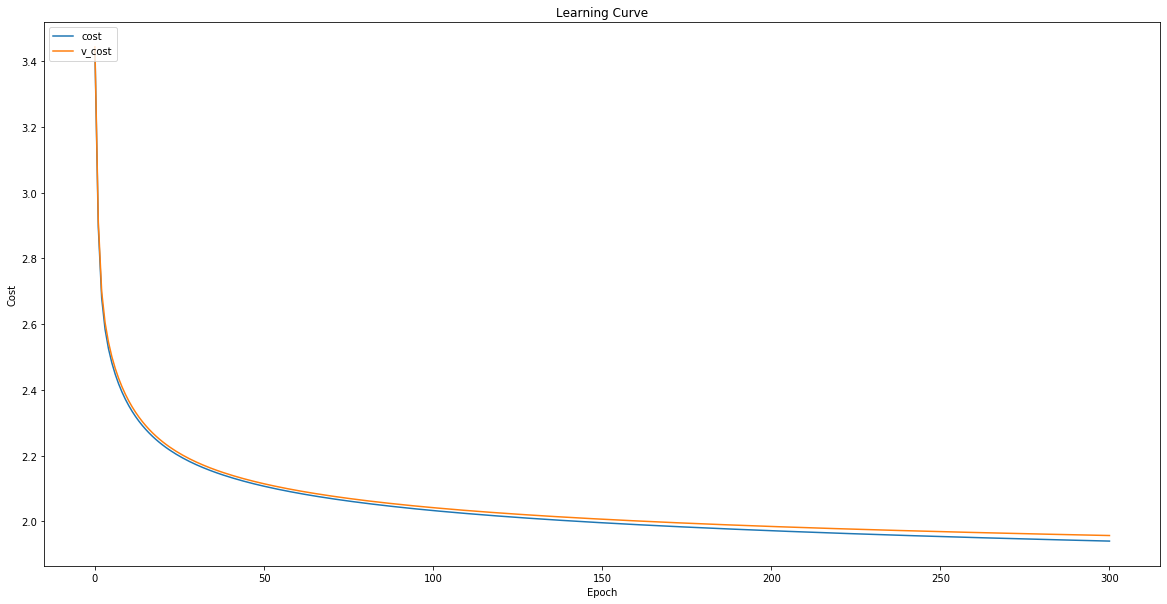

In [11]:
plt.rcParams["figure.figsize"] = (20,10)
learning_with_history(history)

Para avaliar o desempenho do modelo, diversas métricas podem ser utilizadas, como:
- Accuracy
- Precision
- Recall
- F1-Score

Porém, para múltiplas classes, apenas _accuracy_ possui definição escalável. As outras métricas estão definidas **por classe**, e a média pode ser utilizada como métrica única se desejado. Um modo fácil de calcular essas métricas é com a **matriz de confusão** da solução.

In [12]:
# Confusion matrix for the results.
def confusion_matrix(Y, Y_pred, classes):
    conf = np.zeros((classes,classes)).astype('int32')
    for i in range(Y.size):
        conf[Y[i], Y_pred[i]] += 1
    return conf

# Accuracy from confusion matrix. True/total
def accuracy(confusion):
    true_amount = confusion.trace()
    total = confusion.sum()
    return true_amount/total
    
# Precision per class from confusion matrix.
def precision(confusion):
    diag = np.diagonal(confusion)
    return diag/confusion.sum(0)

# Recall per class from confusion matrix.
def recall(confusion):
    diag = np.diagonal(confusion)
    return diag/confusion.sum(1)

# F1 Score per class from precision and recall
def f1_score(prec, rec, bound=1e-8):
    return 2*prec*rec/(prec+rec+bound)
    

# Function to calculate metrics for evaluation
def get_metrics(target, predictions, classes):
    conf = confusion_matrix(target, predictions, classes)
    
    # Metrics
    acc = accuracy(conf)
    prec= precision(conf)
    rec = recall(conf)
    f1 = f1_score(prec, rec)
    avg_acc = (prec + rec)/2
    
    return {'accuracy':acc, 'norm_acc':avg_acc, 'precision':prec, 'recall':rec, 'f1':f1}, conf

A matriz de confusão em si também é interessante de visualizar, por conter muitas informações pertinentes ao desempenho do modelo.

In [13]:
def plot_confusion_matrix(confusion, classes, model='Neural Network'):
    '''
        Plots an already created confusion matrix for a generic amount of classes.
    '''
    
    fig, ax = plt.subplots(1)

    #Bounding box
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')

    plt.title('Confusion Matrix for ' + model)

    #Ticks
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thr = confusion.max()/2
    for i, j in it.product(range(confusion.shape[0]), range(confusion.shape[1])):
        plt.text(j, i, confusion[i, j],
            horizontalalignment='center',
            color='white' if confusion[i, j] > thr else 'black')

    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.imshow(confusion, interpolation='nearest', cmap='Blues')
    plt.show()

    return fig, ax

Com a regressão já feita, podemos testá-la e obter sua matriz de confusão.

In [14]:
def test_logistic(X, Y, T, classes):
    '''
        Tests logistic regression with implemented metrics.
        Accuracy, normalized accuracy, precision, recall, f1-score.
    '''
    
    pred = predict(X, T)
    met, conf = get_metrics(Y, pred, len(classes)) 
    plot_confusion_matrix(conf, classes, model = 'Multinomial Logistic Regression')
    
    np.set_printoptions(precision=4)
    print(f'Accuracy: {met["accuracy"]:.4f}')
    print(f'Normalized Accuracy: {met["norm_acc"].mean():.4f}')
    print(f'Precision per class: {met["precision"]} (avg. precision: {met["precision"].mean():.4f})')
    print(f'Recall per class: {met["recall"]} (avg. recall: {met["recall"].mean():.4f})')
    print(f'F1-Score per class: {met["f1"]} (avg. f1-score: {met["f1"].mean():.4f})')
    print()

Training Metrics:


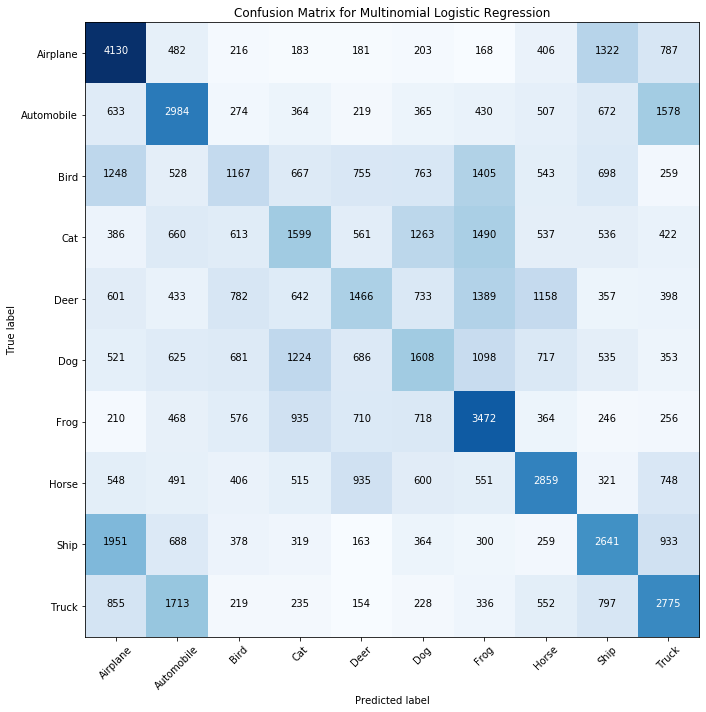

Accuracy: 0.3088
Normalized Accuracy: 0.3037
Precision per class: [0.3726 0.3289 0.2197 0.2393 0.2515 0.2349 0.3263 0.3618 0.325  0.3261] (avg. precision: 0.2986)
Recall per class: [0.5113 0.3718 0.1453 0.1982 0.1842 0.1998 0.4365 0.3585 0.3303 0.3529] (avg. recall: 0.3089)
F1-Score per class: [0.4311 0.349  0.1749 0.2168 0.2126 0.2159 0.3735 0.3602 0.3276 0.339 ] (avg. f1-score: 0.3001)


Validation Metrics:


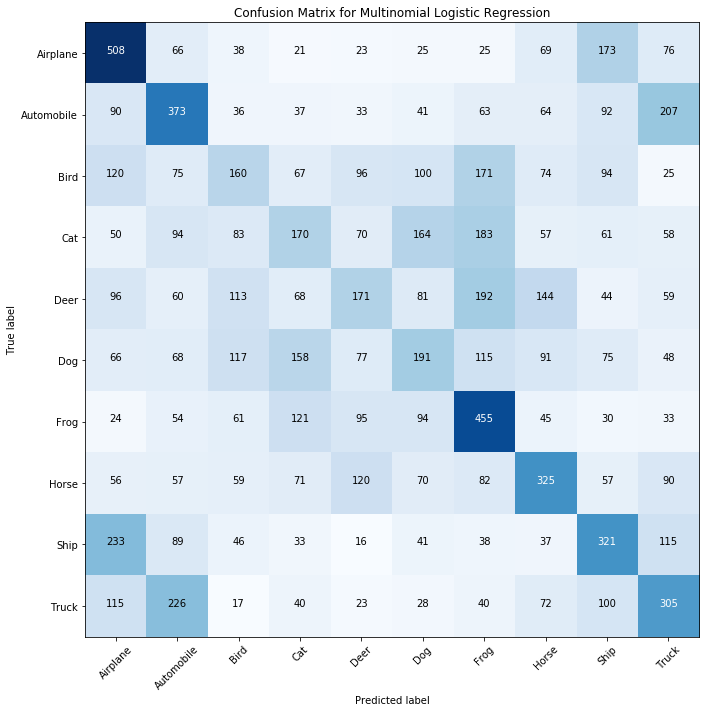

Accuracy: 0.2979
Normalized Accuracy: 0.2921
Precision per class: [0.3741 0.321  0.2192 0.2163 0.2362 0.2287 0.3336 0.3323 0.3066 0.3002] (avg. precision: 0.2868)
Recall per class: [0.4961 0.36   0.1629 0.1717 0.1663 0.1899 0.4496 0.3293 0.3313 0.3157] (avg. recall: 0.2973)
F1-Score per class: [0.4265 0.3394 0.1869 0.1914 0.1952 0.2075 0.383  0.3308 0.3185 0.3078] (avg. f1-score: 0.2887)



In [15]:
# Testing
print("Training Metrics:")
test_logistic(Xb, Y, T, classes)
    
print()
print("Validation Metrics:")
test_logistic(X_vb, Y_v, T, classes)

In [16]:
del Xb, X_vb, T

Como o resultado está longe de satisfatório, devemos perseguir outras técnicas para resolver o problema.

Podemos construir uma **rede neural densa** em seguida, para comparar o desempenho. A rede neural implementada possui três classes:
- Meta, classe que possui metadados do treinamento do modelo, podendo ser utilizada para obter informações para análise.
- Network, classe que representa a rede, podendo ser construída com qualquer quantidade de camadas (maior que 2), com ou sem regularização, e podendo opcionalmente utilizar a função _softmax_ na última camada.
- Optimizer, classe que implementa dois otimizadores para a rede neural: **Adadelta** e **Adam**, que podem ser opcionalmente utilizados.

No momento, exploraremos a rede neural sem otimizadores. A rede implementa _batch_, _stochastic_ e _mini-batch_ _gradient descent_ . Há suporte também para salvar a rede em um arquivo via _NumPy_ ou carregar um arquivo que contém uma rede.

In [17]:
# Set seed based on current time
seed(datetime.now())

def sigmoid(x):
    '''Function for calculating the sigmoid and preventing overflow

        Parameters:
            x (float): Value for which the sigmoid will be calculated

        Returns:
            float : Sigmoid of x
    '''
    # The masks rounds values preventing np.exp to overflow
    x[x >  50] =  50.0
    x[x < -50] = -50.0
    return 1/(1 + np.exp(-x))

In [18]:
class Meta:
    def __init__(self, T, m, l, vl, batch_size, sampling=0):
        self.index = 0  # Saves the position in the random list
        self.iters = 0  # Counts the number of weights updates 
        self.bound = m  # Total amount of samples
        self.best_loss = 0
        self.best_T = T.copy()
        self.epochs_count = 0      # Amount of completed epochs
        self.start_time = time()   # Training start time
        self.sampling = sampling   # Number of iterations which samples are collected
        self.samples_list = list(range(m)) # Radomized samples for stochastic methods
        self.history = {'loss':[l], 'v_loss':[vl]}
        shuffle(self.samples_list)
        
        # Checks it the batch is an integer (n samples) or percentage and, if 
        # it's a percentage, adjust to number of samples
        if not isinstance(batch_size, int) :
            self.batch_size = int(np.ceil(m*batch_size))
        else : 
            self.batch_size = batch_size
        
        # If analysis data will be kept, saves time and thetas
        if (self.sampling):
            self.coef = [deepcopy(T)] # Keeps trained coeficients per epoch
            self.time = [0.0]   # Marks when a ecpoch was complete

    def update(self, cost, samples_sets, T, e_lim):
        '''Updates hyperparameters (epoch count, samples ramdomization)
        
            Parameters:
                T (list of np.ndarray) : Coeficients from the current epoch
                analysis (bool) : If true, keeps arguments for analysis
            Returns:
                change (bool) : if true, epoch finished
        '''
        
        # Update index (add samples used in iteration)
        self.iters += 1
        self.index += self.batch_size
        change = False
        
        # If epoch completed
        if self.index >= self.bound :
            self.index = 0             # Reset samples index
            self.epochs_count += 1     # Count finished epoch
            shuffle(self.samples_list) # Reshuffle samples
            (X,Y,Xv,Yv) = samples_sets
            loss = cost(X,Y)
            v_loss = cost(Xv,Yv)
            self.update_history(loss, v_loss)
            
            # Updates best thetas
            if self.best_loss > v_loss:
                self.best_loss = v_loss
                self.best_T = self.theta.copy()
            print(f"Epoch {self.epochs_count:04d}/{e_lim:04d}", f"loss: {loss:.4f} | val loss: {v_loss:.4f}")

        # Data for further analysis (Consumes time and memory)
        if (self.sampling and self.iters//self.sampling) :
            self.iters = 0
            self.time.append(time() - self.start_time) # Adds time until epoch is done
            self.coef.append(deepcopy(T)) # Adds current epoch cost
            
        return change

    def update_history(self, loss, v_loss):
        self.history['loss'].append(loss)
        self.history['v_loss'].append(v_loss)
        
    def get_batch(self):
        '''Get samples indexes for the next batch'''
        return self.samples_list[self.index : self.index+self.batch_size]

    def __str__(self):
        out = f'<Meta Object at {hex(id(self))}>'
        out += f'Samples per Epoch: {self.bound}'
        out += f'Current samples index: {self.index}'
        out += f'Batch size: {self.batch_size}'
        out += f'Epochs complete so far: {self.epochs_count}'
        return out

In [19]:
class Network:
    def __init__(self, model, f='sg', reg_lambda=0, T=0, seed=0):
        '''Initializes coeficients tables with the network weights
        
        Parameters: 
            model (list) : List with the amount of nodes per layer (without bias)
            f (String) : Identification for the function to be minimized
            reg_lambda (float) : Regularization parameter for the network (0 disables regularization)
            T (list of numpy.ndarray): If instanciated, uses T as initial thetas
        '''
        self.reg_lambda = reg_lambda
        self.f = f
        self.theta = []

        # Generates a random seed based on current time
        if not seed : int(divmod(time(), 1)[1])

        # If no preset, instanciate thetas and set random initial thetas
        for (n,m) in zip(model[1:],model[:-1]): 
            # Instanciate weights with Xavier initialization
            rand = np.random.RandomState(seed=seed)
            self.theta.append((np.sqrt(2/(m+1)) * rand.randn(n,m+1)).astype(np.float32))

    def cost(self, X, Y):
        '''Calculates the current cost for the given samples (features and outputs)

        Parameters:
            X (numpy.ndarray): NxM matrix with N features and M samples
            Y (numpy.ndarray): KxM matrix with K output nodes and M samples

        Returns:
            float : Total cost for the current network and the given samples 
        '''
        reg = 0 # Regularization value (weight reduction)
        e = 10**-6 # Offset used to avoid log(0) (prevents NaNs)
        m = Y.shape[1]  # Get amount of samples
        fun = lambda x : (x[:,1:]*x[:,1:]).sum() # Sum squared parameters without bias 
        H = self.frag_forward(X, 10) # Get output layer activation values

        # Calculate cost function
        if self.f == 'sg': # Use sigmoid cost
            cost = -(Y*np.log(H+e) + (1-Y)*np.log((1+e)-H)).sum()/m
        elif self.f == 'sm': # Use softmax cost
            cost_mat = softmax(H)
            cost = (-Y * np.log(cost_mat+e)).sum(axis=0).mean()

        # Calculate regularization, if parameter is set
        if self.reg_lambda : reg = self.reg_lambda*(sum(map(fun, self.theta))/(2*m))

        return cost + reg

    def cost_deriv(self, H, Y):
        '''Calculates the current cost for the given samples (features and outputs)

        Parameters:
            H (numpy.ndarray): NxM matrix with output layer activation values (N node X M samples)
            Y (numpy.ndarray): KxM matrix with K output nodes and M samples

        Returns:
            float : Total cost for the current network and the given samples 
        '''
        m = Y.shape[1]  # Get amount of samples

        if self.f =='sg': # Use sigmoid derivative
            return H - Y
        elif self.f == 'sm': # Use softmax derivative
            return softmax(H) - Y

    def forward(self, features, nodes=0):
        '''Execute the forward propagation using the defined thetas
        
        Parameters: 
            features (numpy.ndarray) : Column vector with input features (without bias)
            nodes (list) : if instanciated, saves the nodes activation values for every layer

        Returns:
            numpy.ndarray : Array with the propagated value for the output layer
        '''
        m = features.shape[1] # Get amount of samples to be propagated

        for table in self.theta :
            features = np.insert(features, 0, 1, axis=0)
            if isinstance(nodes, list) : nodes += [features] 
            features = sigmoid(table.dot(features))

        if isinstance(nodes, list) : nodes += [features]
        return features

    def backprop(self, X, Y):
        '''Execute gradient calculation for the given thetas and samples
        
        Parameters: 
            X (numpy.ndarray) : NxM matrix with M samples and each sample with N features
            Y (numpy.ndarray) : KxM matrix with M samples ana each samples with K output nodes

        Returns:
            list of numpy.ndarray : Gradients for each set of thetas in the network 
        '''
        reg_lambda = self.reg_lambda # Regularization parameter
        theta = self.theta # Alias for the parameters
        m = Y.shape[1] # Amount of samples to be backpropagated

        layer = [] # For keeping the activation values
        grad = [np.zeros(i.shape) for i in theta] # For keeping the partial derivatives
        H = self.forward(X, nodes=layer) # Calculate hypotesis for every output node of every sample
        sigma = [np.zeros(i.shape) for i in layer[1:]] # For keeping the activation errors (except input layer)
        reg = 0

        sigma[-1] = self.cost_deriv(H, Y)
        
        # Back propagate error to hidden layers (does not propagate to bias nodes)
        for i in reversed(range(1, len(sigma))):
            sig_d = layer[i][1:,:]*(1-layer[i][1:,:]) # Remove bias from layers for backpropagation
            sigma[i-1] = (theta[i][:,1:].T).dot(sigma[i])*sig_d # Remove bias from thetas as well

        # Accumulate derivatives values for every theta (does not update thetas)
        # - Biases are not regularized, so the bias weights are casted to zero
        for i in range(len(grad)):
            if reg_lambda : reg = np.insert(theta[i][:,1:]*reg_lambda, 0, 0, axis=1)
            grad[i] = (grad[i] + sigma[i].dot(layer[i].T))/m + reg
        
        return grad

    def train(self, X, Y, Xv, Yv, type='m', opt=None, t_lim=7000, e_lim=100000, rate=0.01, mb_size=32, sampling=0, betas=(0,0)):
        '''Trains the model until one of the given limits are reached

        Parameters:
            X (Float 2dArray): The coeficient matrix.
            Y (Float 2dArray): The results matrix.
            type (int): The choice of descent ('s'-stoch|'m'-mini|'b'-batch)
            opt (String): Selects the optimizer for the decent (None|adadelta|adam)

        Returns:
            Meta : Class containing the runtime info.
        '''
        # Initializes epochs metadata class
        batch_size = {'b':Y.shape[1],'m':mb_size,'s':1}.get(type) # Get number of samples
        data = Meta(self.theta, Y.shape[1], self.cost(X,Y), self.cost(Xv,Yv), batch_size, sampling=sampling) # Saves hyperparameters and other info for analisys 
        optmizer = Optimizer(rate, choice=opt, T=self.theta, batch=mb_size, beta=betas)

        # Starting descent
        while (time() - data.start_time) <= t_lim:
            # Getting new Thetas
            b = data.get_batch() # Get indexes for mini batch
            grad = self.backprop(X[:,b], Y[:,b])    
            delta = optmizer.optimize(grad)
            
            # Update coefficients
            for i in range(len(delta)):
                self.theta[i] += delta[i]

            data.update(self.cost, (X,Y,Xv,Yv), self.theta, e_lim)
            
            # Check termination
            if data.epochs_count >= e_lim : 
                print("NOTE: Epochs limit for descent reached.")  
                self.theta = data.best_T     
                return data
            
        print("NOTE: Time limit for descent exceded.")
        self.theta = data.best_T
        return data

    def frag_forward(self, X, parts):
        '''Wrapper for the forward propagation which splits the M samples in slices
           Prevents numpy memory spikes during large matrix multiplications           

        Parameters:
            X (Float 2dArray): NxM matrix with N input feratures and M samples
            type (int): The choice of descent ('s'-stoch|'m'-mini|'b'-batch).

        Returns:
            numpy.ndarray : Array with the propagated value for the output layer
        '''
        m = X.shape[1]
        size = int(np.ceil(m/parts)) # Get size of each batch
        out_layer = np.zeros((self.theta[-1].shape[0],m)) # Prealocate output layer
        batches = [i*size for i in range(int(np.ceil(parts)+1))] # Slices indexes
        for (s,e) in zip(batches[:-1], batches[1:]): # Propagate for each slice
            out_layer[:,s:e] += self.forward(X[:,s:e])
        return out_layer

    def accuracy(self, X, Y, T=0):
        '''Caculates the cost for a set of samples in the current network
        
            Parameters:
                X (Float 2dArray): NxM matrix with N input features and M samples
                Y (Int 2dArray): NxM matrix with the expected M output layers
            
            Returns:
                float : Percentage of correct predictions for the M samples
        '''
        m = Y.shape[1] 
        H = self.frag_forward(X, 10)
        H = H.argmax(axis=0)
        Y = Y.argmax(axis=0)
        hits = (H==Y).sum()
        return hits*100/m
    
    def predict(self, X):
        '''
           Predicts classes of examples.
           
           Parameters:
                X (Float 2dArray): NxM matrix with N input features and M samples
                
           Returns:
                Int Array: N-dimensional array with predictions
        '''
        
        H = self.frag_forward(X, 10)
        H = H.argmax(axis=0)
        return H

    def save(self, file_name):
        '''Function for saving the current network to a file'''
        save_list = [np.array([self.reg_lambda,self.f])]
        save_list += self.theta
        np.savez(file_name, save_list)
        print(f"Model saved as {file_name}")
 
    def load(self, file_name):
        '''Function for loading a Network from a file'''
        obj = np.load(file_name)
        self.reg_lambda = int(obj['arr_0'][0][0])
        self.f = str(obj['arr_0'][0][1])
        self.theta = []
        for T in obj['arr_0'][1:]:
            self.theta.append(T)
        print(f"Model {file_name} loaded")

    def __str__(self):
        funcs = {'sg':'Sigmoid', 'sm':'Softmax'}
        out = f'<Network Object at {hex(id(self))}>\n'
        out += f'Composed of {len(self.theta)+1} layers:\n'
        for i,n in enumerate(self.theta):
            out += f'   layer {i+1} - {n.shape[1]} nodes\n'
        out += f'   Out layer - {self.theta[-1].shape[0]} nodes\n'
        out += f'Cost function: {funcs[self.f]}\n'
        out += f'Regularization parameter: {self.reg_lambda}\n'
        out += f'Amount of weights: {sum([x.size for x in self.theta])}\n'
        return out

In [20]:
class Optimizer:
    def __init__(self, rate, choice=None, T=0, batch=0, beta=(0,0)):
        self.choice = choice
    
        if choice=='adadelta':
            self.e = 10**-8
            self.decay = 0.99
            self.batch = batch 
            self.avg = [np.zeros(t.shape) for t in T]
            self.delta = [np.zeros(t.shape) for t in T]
        elif choice=='adam':
            self.e = 1e-8
            self.rate = rate
            self.t = 0
            self.beta = beta
            self.mt = [np.zeros(t.shape) for t in T]
            self.vt = [np.zeros(t.shape) for t in T]
            self.batch = batch
        else:
            self.rate = rate
        
    def optimize(self, grad):
        
        if self.choice=='adadelta':
            delta = self.adadelta(grad)
        elif self.choice=='adam':
            delta = self.adam(grad)
        else: # Vanilla
            delta = [-self.rate*g for g in grad]
        return delta

    def adadelta(self, grad):
        eps = self.e
        decay = self.decay
        batch = self.batch
        new_deltas = []
        for i,(g,avg,delta) in enumerate(zip(grad, self.avg, self.delta)):
            # Calculate new optimized delta
            avg = decay*avg + (1-decay)*np.square(g)
            new_deltas.append(-(np.sqrt(delta+eps)/np.sqrt(avg+eps))*g)
            # Updates for next iteration
            self.avg[i] = avg
            self.delta[i] = decay*delta + (1-decay)*np.square(new_deltas[-1])

        return new_deltas
    
    def adam(self, grad):
        self.t+=1
        mt = self.mt
        vt = self.vt
        new_deltas = []
        
        for i,g in enumerate(grad):
        
            # Calculating moving averages
            mt[i] = self.beta[0]*mt[i] + (1-self.beta[0])*g
            vt[i] = self.beta[1]*vt[i] + (1-self.beta[1])*g*g
            
            # Bias-corrected estimates for moment
            mt_b = mt[i]/(1-(self.beta[0]**self.t))
            vt_b = vt[i]/(1-(self.beta[1]**self.t))
            
            delta = -1 * (self.rate * mt_b)/(np.sqrt(vt_b)+self.e)
            new_deltas.append(delta)
        
        # Update
        self.mt = mt
        self.vt = vt
        
        return new_deltas

Com algumas adaptações, as funções de teste podem ser as mesmas. Porém, a entrada necessita de pré-processamento, pois ao contrário da regressão logística, a rede neural implementada utiliza _One-Hot Encoding_ na camada de saída.

O método _predict_ da classe _Network_ retorna a saída ao formato original, para avaliação.

In [21]:
def out_layers(array):
    '''Converts values from a list to one hot enconded output layers

        Parameters:
            array (list of ints): Contains the integer ID for each class
    
        Returns:
            np.ndarray : 2D array where each colum is a output layer
    '''
    lower = min(array)
    upper = max(array)
    lines = upper-lower+1
    new_arr = np.zeros((lines,len(array)), dtype=np.int8)

    for j,i in enumerate(map(lambda x : x-lower, array)):
       new_arr[i,j] = 1

    return new_arr

Podemos fazer um _wrapper_ para criar a rede, com uma arquitetura testada anteriormente que forneceu bons resultados.
O wrapper também transpõe os dados de entrada, já que este, diferentemente da regressão logística, considera as linhas sendo Features e as colunas como Samples.

In [22]:
def create_neural_network(X, Y, Yv, reg=0, f='sg'):
    '''
        Creates fully-connected neural network.
        Parameters:
            X,Xv: MxN matrix with N input features and M samples
            Y,Yv: M-dimensional array with target values.
            reg : regularization parameter
            f   : activation function of choice (sg: sigmoid | sm: softmax)
    '''
    
    # Adjusting input matrices (assumes X is normalized)
    Yn = out_layers(Y)
    Yvn=out_layers(Yv)
    print("Handled input")
    
    # Builds network object
    feat, out = X.T.shape[0], Yn.shape[0]
    h1, h2 = 256, 128
    arc = [feat, h1, h2, out]
    model = Network(arc, f=f, seed=23, reg_lambda=reg)
    print('Created model')
    print(f"Initial Accuracy: {(model.accuracy(X.T, Yn)/100):.4f}")
    
    return Yn, Yvn, model


Com isso, temos o que precisamos para treinar a rede, que utilizará **Mini-Batch Gradient Descent**.
Após diversos testes, bons parâmetros encontrados consistem em utilizar batches de tamanho 256, e _learning rate_ de 0.01. A função _softmax_ não foi utilizada pois seu resultado é pior. Os outros parâmetros foram escolhidos arbitrariamente.

In [23]:
Yn, Yvn, model = create_neural_network(X, Y, Y_v)
data = model.train(X.T, Yn, X_v.T, Yvn, type='m', mb_size=256, e_lim=500, t_lim=300, rate=0.01)

Handled input
Created model
Initial Accuracy: 0.1021
Epoch 0001/0500 loss: 3.0841 | val loss: 3.0882
Epoch 0002/0500 loss: 3.0132 | val loss: 3.0187
Epoch 0003/0500 loss: 2.9662 | val loss: 2.9718
Epoch 0004/0500 loss: 2.9331 | val loss: 2.9388
Epoch 0005/0500 loss: 2.9087 | val loss: 2.9143
Epoch 0006/0500 loss: 2.8898 | val loss: 2.8959
Epoch 0007/0500 loss: 2.8740 | val loss: 2.8804
Epoch 0008/0500 loss: 2.8608 | val loss: 2.8679
Epoch 0009/0500 loss: 2.8493 | val loss: 2.8569
Epoch 0010/0500 loss: 2.8385 | val loss: 2.8460
Epoch 0011/0500 loss: 2.8289 | val loss: 2.8370
Epoch 0012/0500 loss: 2.8201 | val loss: 2.8284
Epoch 0013/0500 loss: 2.8120 | val loss: 2.8211
Epoch 0014/0500 loss: 2.8047 | val loss: 2.8145
Epoch 0015/0500 loss: 2.7981 | val loss: 2.8082
Epoch 0016/0500 loss: 2.7919 | val loss: 2.8023
Epoch 0017/0500 loss: 2.7857 | val loss: 2.7969
Epoch 0018/0500 loss: 2.7803 | val loss: 2.7922
Epoch 0019/0500 loss: 2.7750 | val loss: 2.7873
Epoch 0020/0500 loss: 2.7700 | val 

Os testes são feitos de maneira similar à regressão logística.

In [24]:
def test_neural_network(X, Y, model, classes):
    '''
        Function to test neural network.
    '''
    pred = model.predict(X)
    met, conf = get_metrics(Y, pred, len(classes)) 
    plot_confusion_matrix(conf, classes, model='Neural Network')
    
    np.set_printoptions(precision=4)
    print(f'Accuracy: {met["accuracy"]:.4f}')
    print(f'Normalized Accuracy: {met["norm_acc"].mean():.4f}')
    print(f'Precision per class: {met["precision"]} (avg. precision: {met["precision"].mean():.4f})')
    print(f'Recall per class: {met["recall"]} (avg. recall: {met["recall"].mean():.4f})')
    print(f'F1-Score per class: {met["f1"]} (avg. f1-score: {met["f1"].mean():.4f})')
    print()

Training Metrics:


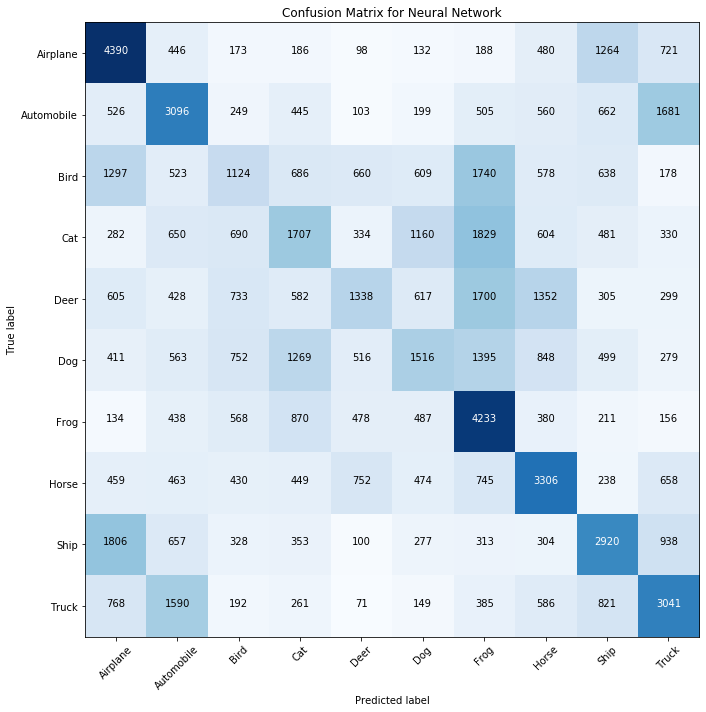

Accuracy: 0.3334
Normalized Accuracy: 0.3277
Precision per class: [0.4111 0.3497 0.2145 0.2507 0.3007 0.2698 0.3248 0.3674 0.3632 0.3672] (avg. precision: 0.3219)
Recall per class: [0.5435 0.3857 0.1399 0.2116 0.1681 0.1884 0.5321 0.4146 0.3652 0.3867] (avg. recall: 0.3336)
F1-Score per class: [0.4681 0.3668 0.1694 0.2295 0.2156 0.2218 0.4034 0.3896 0.3642 0.3767] (avg. f1-score: 0.3205)

Validation Metrics:


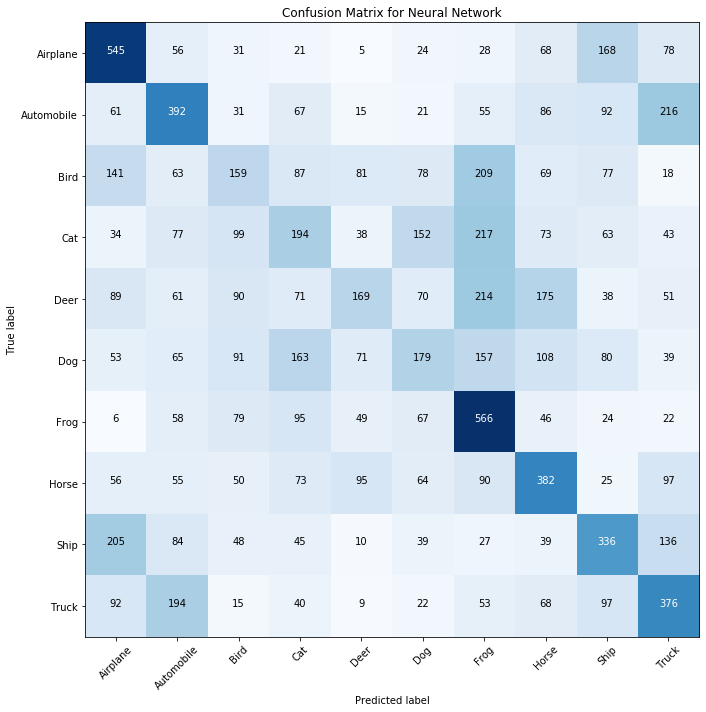

Accuracy: 0.3298
Normalized Accuracy: 0.3235
Precision per class: [0.4251 0.3548 0.2294 0.2266 0.3118 0.25   0.3502 0.3429 0.336  0.3494] (avg. precision: 0.3176)
Recall per class: [0.5322 0.3784 0.1619 0.196  0.1644 0.1779 0.5593 0.387  0.3467 0.3892] (avg. recall: 0.3293)
F1-Score per class: [0.4727 0.3662 0.1899 0.2102 0.2153 0.2079 0.4307 0.3636 0.3413 0.3683] (avg. f1-score: 0.3166)



In [25]:
print("Training Metrics:")
test_neural_network(X.T, Y, model, classes)
    
print("Validation Metrics:")
test_neural_network(X_v.T, Y_v, model, classes)

Pode-se ver que o resultado é melhor do que o visto para a regressão logística, porém ainda pode melhorar.
Podemos utilizar os otimizadores implementados, e comparar os resultados.

Nos testes com otimizadores, os hiperparâmetros mudaram. Um batch size de 1024, por exemplo, não funciona bem para a rede original, mas funciona melhor que o tamanho original para os otimizadores.

In [26]:
def optimization_cost(X, Y, Xv, Yv, m=80000):
    plot_info = []

    samples = sample(range(Y.shape[1]), m)
    X = X[:,samples]
    Y = Y[:,samples]
    feat = X.shape[0]
    out = Y.shape[0]

    # Set constant hyperparameters
    e=50
    t=200
    r=0.001
    b=1024
    
    # Variable aspects/hyperparams per plot
    opt = ['adam','adadelta', None]
    title = ['Adam', 'Adadelta', 'Vanilla']
    arc = [3072, 256, 128, 10]

    print("Architecture:", arc)
    for i in range(len(title)):
        model = Network(arc, seed=23)
        data = model.train(X, Y, Xv, Yv,
                            opt=opt[i], 
                            type='m', 
                            t_lim=t, 
                            e_lim=e, 
                            rate=r, 
                            mb_size=b, 
                            betas=(0.9,0.999))
        plot_info.append((title[i], range(0,data.epochs_count+1), data.history['loss']))
        plot_info.append((title[i]+'(Validation)', range(0,data.epochs_count+1), data.history['v_loss']))
        print(title[i]+':', model.accuracy(Xv,Yv), '%')


    for (l,x,y) in plot_info : plt.plot(x, y, label=l)
    plt.title(f"Learning Curve \n {m} samples | {t} sec")
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.legend()
    plt.show()


Architecture: [3072, 256, 128, 10]
Epoch 0001/0050 loss: 2.7914 | val loss: 2.8050
Epoch 0002/0050 loss: 2.7116 | val loss: 2.7404
Epoch 0003/0050 loss: 2.6553 | val loss: 2.6988
Epoch 0004/0050 loss: 2.6070 | val loss: 2.6689
Epoch 0005/0050 loss: 2.5654 | val loss: 2.6470
Epoch 0006/0050 loss: 2.5306 | val loss: 2.6277
Epoch 0007/0050 loss: 2.4872 | val loss: 2.6061
Epoch 0008/0050 loss: 2.4425 | val loss: 2.5934
Epoch 0009/0050 loss: 2.4093 | val loss: 2.5849
Epoch 0010/0050 loss: 2.3765 | val loss: 2.5789
Epoch 0011/0050 loss: 2.3379 | val loss: 2.5718
Epoch 0012/0050 loss: 2.2887 | val loss: 2.5587
Epoch 0013/0050 loss: 2.2491 | val loss: 2.5556
Epoch 0014/0050 loss: 2.2124 | val loss: 2.5621
NOTE: Time limit for descent exceded.
Adam: 40.48 %
Epoch 0001/0050 loss: 2.8878 | val loss: 2.8948
Epoch 0002/0050 loss: 2.8251 | val loss: 2.8364
Epoch 0003/0050 loss: 2.7813 | val loss: 2.7967
Epoch 0004/0050 loss: 2.7541 | val loss: 2.7738
Epoch 0005/0050 loss: 2.7313 | val loss: 2.7534
E

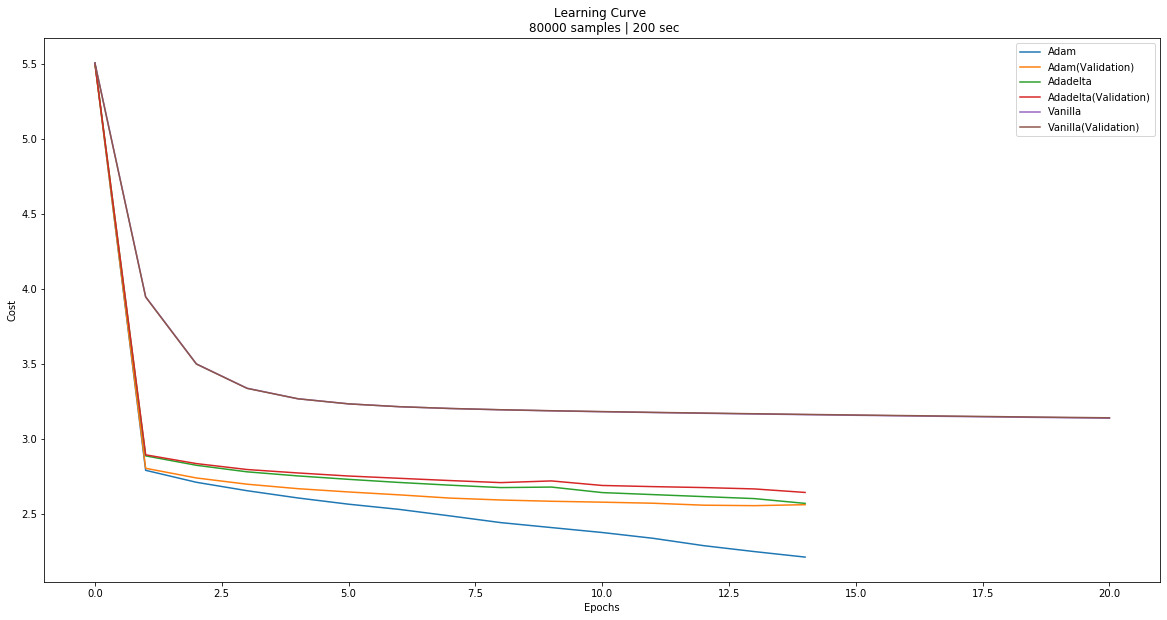

In [27]:
del model, data
gc.collect()
optimization_cost(X.T, Yn, X_v.T, Yvn)

É perceptível no resultado das comparações que o modelo com otimizador Adam sofreu _overfit_ , e por isso o custo de validação volta a subir no final. Esse modelo também é o que gerou melhores resultados nesse teste, então será considerado o melhor.

Para impedir _overfitting_ , no treinamento final será utilizado um fator de regularização de 0.002, assim deixando a convergência mais lenta, então o tempo limite foi aumentado.

In [28]:
Yn, Yvn, model = create_neural_network(X, Y, Y_v, reg=0.002)
data = model.train(X.T, Yn, X_v.T, Yvn, type='m', opt='adam', mb_size=1024, e_lim=500, t_lim=900, rate=0.001, betas=(0.9,0.999))

Handled input
Created model
Initial Accuracy: 0.1021
Epoch 0001/0500 loss: 2.8051 | val loss: 2.8194
Epoch 0002/0500 loss: 2.7569 | val loss: 2.7740
Epoch 0003/0500 loss: 2.7299 | val loss: 2.7498
Epoch 0004/0500 loss: 2.7066 | val loss: 2.7338
Epoch 0005/0500 loss: 2.6972 | val loss: 2.7277
Epoch 0006/0500 loss: 2.6808 | val loss: 2.7126
Epoch 0007/0500 loss: 2.6725 | val loss: 2.7043
Epoch 0008/0500 loss: 2.6742 | val loss: 2.7105
Epoch 0009/0500 loss: 2.6525 | val loss: 2.6878
Epoch 0010/0500 loss: 2.6568 | val loss: 2.6947
Epoch 0011/0500 loss: 2.6350 | val loss: 2.6776
Epoch 0012/0500 loss: 2.6197 | val loss: 2.6625
Epoch 0013/0500 loss: 2.6131 | val loss: 2.6582
Epoch 0014/0500 loss: 2.6197 | val loss: 2.6704
Epoch 0015/0500 loss: 2.6094 | val loss: 2.6535
Epoch 0016/0500 loss: 2.5968 | val loss: 2.6447
Epoch 0017/0500 loss: 2.5743 | val loss: 2.6224
Epoch 0018/0500 loss: 2.5910 | val loss: 2.6442
Epoch 0019/0500 loss: 2.5645 | val loss: 2.6165
Epoch 0020/0500 loss: 2.5656 | val 

Training Metrics:


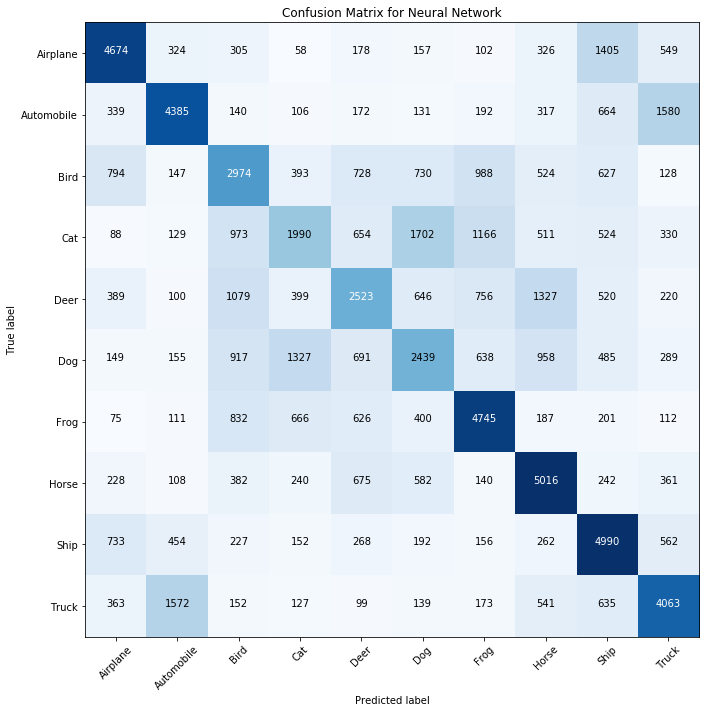

Accuracy: 0.4725
Normalized Accuracy: 0.4690
Precision per class: [0.5968 0.5858 0.3726 0.3646 0.3815 0.3427 0.524  0.5032 0.4848 0.4959] (avg. precision: 0.4652)
Recall per class: [0.5786 0.5463 0.3702 0.2467 0.317  0.3031 0.5965 0.629  0.6241 0.5167] (avg. recall: 0.4728)
F1-Score per class: [0.5876 0.5654 0.3714 0.2943 0.3463 0.3216 0.5579 0.5591 0.5457 0.506 ] (avg. f1-score: 0.4655)

Validation Metrics:


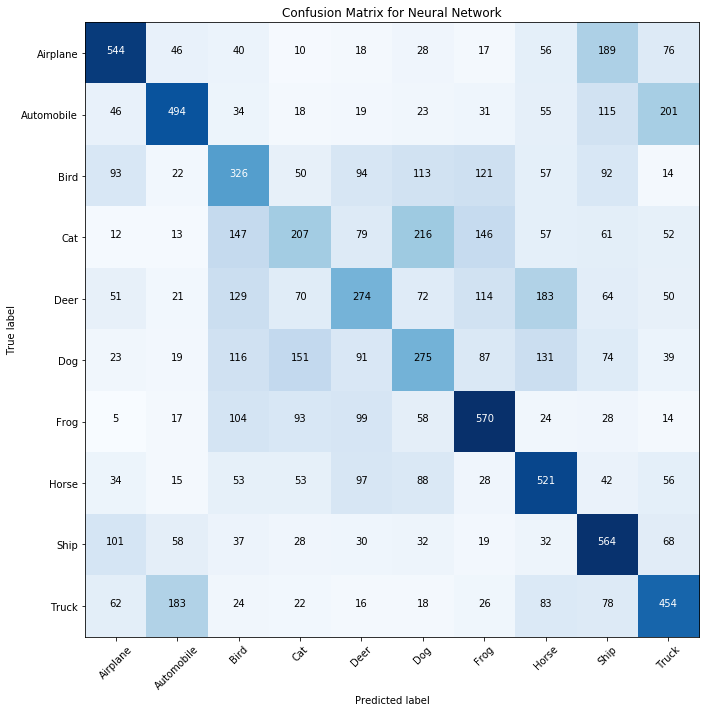

Accuracy: 0.4229
Normalized Accuracy: 0.4200
Precision per class: [0.5602 0.5563 0.3228 0.2949 0.3354 0.2979 0.4918 0.4345 0.4315 0.4434] (avg. precision: 0.4169)
Recall per class: [0.5312 0.4768 0.332  0.2091 0.2665 0.2734 0.5632 0.5279 0.582  0.47  ] (avg. recall: 0.4232)
F1-Score per class: [0.5454 0.5135 0.3273 0.2447 0.297  0.2851 0.5251 0.4767 0.4956 0.4563] (avg. f1-score: 0.4167)



In [29]:
print("Training Metrics:")
test_neural_network(X.T, Y, model, classes)
    
print("Validation Metrics:")
test_neural_network(X_v.T, Y_v, model, classes)

Como esse modelo foi escolhido como o melhor, podemos verificar o **conjunto de teste** nele.

In [30]:
del X, Y, Yn, Yvn, X_v, Y_v, train, valid
gc.collect()

18739

In [31]:
test = np.load('Dataset/test.npz')
X_t, Y_t = test['xs'], test['ys'].astype('int8')
X_t = normalize_data(X_t, stats, choice)
print("Test Data Normalized!")

Test Data Normalized!


Test Metrics:


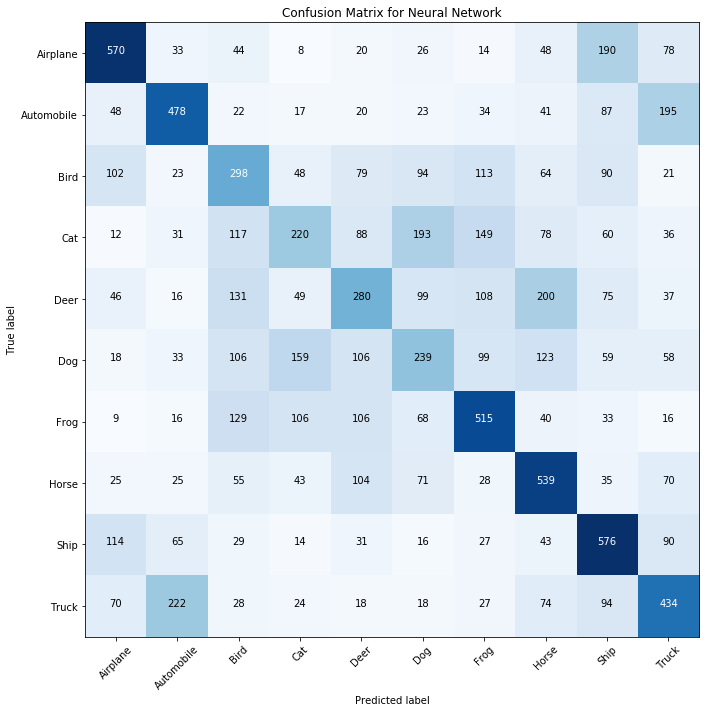

Accuracy: 0.4149
Normalized Accuracy: 0.4104
Precision per class: [0.5621 0.5074 0.3107 0.3198 0.3286 0.2822 0.4623 0.4312 0.4434 0.4193] (avg. precision: 0.4067)
Recall per class: [0.5529 0.4953 0.3197 0.2236 0.269  0.239  0.4961 0.5417 0.5731 0.4301] (avg. recall: 0.4141)
F1-Score per class: [0.5575 0.5013 0.3152 0.2632 0.2958 0.2588 0.4786 0.4802 0.5    0.4247] (avg. f1-score: 0.4075)



In [32]:
print("Test Metrics:")
test_neural_network(X_t.T, Y_t, model, classes)